# Assignment 2 - Zhihan Yang: Electricity Usage IAM Challenge, Group 16
## Describe :

### Description from data holder:


<blockquote>The data provided comes from two projects:<br>
    
SMILE – 2020 data from 7 homes with single occupancy <br>
    
IDEAL Household Energy Dataset – 2017/2018 data from 8 homes with single occupancy <br>
    
All data is from Individual Appliance Monitors or IAMs. These are plug-level monitors that measure instantaneous power from household appliances. All values are in Watts. Please note that IAMs report changes in power use, rather than reporting at regular intervals. All data is in compressed CSV format; the CSV has two fields: timestamp and value.
</blockquote>

### Description from myself:

#### The general description of the data: 

The data records the use of household electrical appliances for an elderly person in a certain period of time in the form of tabular. There are 2 main big data sets, which are called IDEAL and SMILE. Each data set has lots of small data sets, which represet different appliances usage history in different families. There are 8 families and 51 different data sets in in IDEAL data set(because each family may have different appliances), ranging from 2017.4\~2018.6. There are 7 families and 27 different data sets in in SMILE data set, ranging from 2020.1\~2020.10. Each small each data set represents a specific appliance in a specific home and we could know what the homeid, roomid, room_type, category, subtype, sensorid are by its file name（subtype refers to the name of appliance）. There are two columns in each small each data: time stamp and instantaneous power when using appliances. The sensor collects power data approximately every seven seconds when the appliance is in use, and approximately once every hour when it is not in use. There is also a extenal data set, which has information of 7 elders in SMILE data set's: Home ID, Gender, DateOfBirth, Age, StaffPlanConditions, CareSysCondition, Location.


#### The structure of the data: 

78 main files + 1 extenal file.

Each main file: 10000(approximately) * 2, with homeid, roomid, room_type, category, subtype, sensorid in the file name. （.csv.gz file）

Extenal file: 7 * 7 （.csv file）

#### Links between this data and other data

If the homeid of two data is same, it represents that these two data coming from one same home and one same elder(each home just has one person).

#### How does the data relate to the questions that the data owner has discussed with you?

We need to use these data to find patterns of electrical appliances usage in these elderly families.




## Explore:

### Setup

First, load the data from the supplied data file

Here we use the IdealDataInterface library to access the data, which is provided by the data holder.

In [1]:
%pylab inline
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time
from scipy import stats, integrate
from IdealDataInterface import IdealDataInterface

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 100)

Populating the interactive namespace from numpy and matplotlib


In [2]:
folder_path = './IAM_Data/IDEAL'
ideal = IdealDataInterface(folder_path)
folder_path = './IAM_Data/SMILE'
smile = IdealDataInterface(folder_path)

Found entries for 51 sensor readings.
Found entries for 27 sensor readings.


Here, ideal and smile are two big data sets and these two objects are two instances of IdealDataInterface class.

In [3]:
# Have a look at the room types in all IDEAL data sets
ideal.room_types()

room_type
kitchen       42
hall           5
outside        2
diningroom     1
bedroom        1
dtype: int64

IdealDataInterface class has many method. In this notebook, we mainly use the get( ) method to get the data.

In [4]:
# Have a look at the appliances types in all IDEAL data sets
ideal.categories()

,category,subtype
0,electric-appliance,microwave
1,electric-appliance,kettle
2,electric-appliance,washingmachine
3,electric-appliance,other
4,electric-appliance,fridgefreezer
...,...,...
9,electric-appliance,freezer
10,electric-appliance,electricheater
11,electric-appliance,fridge
12,electric-appliance,dehumidifier


In [5]:
# Have a look at the microwave keys in home 90
ideal.view(homeid=90, subtype='microwave')

,homeid,roomid,room_type,category,subtype,sensorid
0,90,957,kitchen,electric-appliance,microwave,4859


Here, we use get( ) method to get the data of home 90. The data we get is dictionaries in a list, cotaining homeid,roomid,..., and the real usage data of different appliances. Use indexs of list to refer different appliances.

In [6]:
# Get the data of microwave in home 90
data = ideal.get(homeid=90)
data

[{'homeid': '90',
  'roomid': '957',
  'room_type': 'kitchen',
  'category': 'electric-appliance',
  'subtype': 'microwave',
  'sensorid': '4859',
  'readings': time
  2017-04-11 10:00:59      3
  2017-04-11 10:01:00    248
  2017-04-11 10:01:01      1
  2017-04-11 10:33:42      0
  2017-04-11 10:33:46      3
                        ... 
  2018-06-19 09:01:55      3
  2018-06-19 10:01:55      3
  2018-06-19 11:01:55      3
  2018-06-19 12:01:55      3
  2018-06-19 13:01:55      3
  Name: sensor_4859, Length: 12445, dtype: int64},
 {'homeid': '90',
  'roomid': '957',
  'room_type': 'kitchen',
  'category': 'electric-appliance',
  'subtype': 'fridgefreezer',
  'sensorid': '4860',
  'readings': time
  2017-04-11 10:01:14    251
  2017-04-11 10:01:15      0
  2017-04-11 10:33:41      0
  2017-04-11 10:33:42    578
  2017-04-11 10:33:44     84
                        ... 
  2018-06-30 23:57:51      0
  2018-06-30 23:58:33      0
  2018-06-30 23:58:35      0
  2018-06-30 23:59:45      0
  20

As said before, each element in the list is a dictionary.

In [7]:
# Have a look at the data keys
data[0].keys()

dict_keys(['homeid', 'roomid', 'room_type', 'category', 'subtype', 'sensorid', 'readings'])

The value in the key of 'readings' is the real data of the appliance usage. It is a pandas.series, where the index is time and the value is the power.

In [8]:
# Have a look at the data
s1 = data[0]['readings']
s1

time
2017-04-11 10:00:59      3
2017-04-11 10:01:00    248
2017-04-11 10:01:01      1
2017-04-11 10:33:42      0
2017-04-11 10:33:46      3
                      ... 
2018-06-19 09:01:55      3
2018-06-19 10:01:55      3
2018-06-19 11:01:55      3
2018-06-19 12:01:55      3
2018-06-19 13:01:55      3
Name: sensor_4859, Length: 12445, dtype: int64

In [9]:
# Have a look at the data describe
s1.describe(include = "all")

count    12445.000000
mean        79.795741
std        315.785626
min          0.000000
25%          2.000000
50%          3.000000
75%          3.000000
max       1496.000000
Name: sensor_4859, dtype: float64

Here, we could see that min is 0 and 75% is 3, which means that most of value of power is less than 3. So we can conclude that 0~3 can refer to the appliance is not in used(the power is too low to run the appliance and the power is not zero because there may be some measurement errorit of the sensor).

### Cleaning

The "right" data should be:
1. The index(time) should be exclusive(no duplication). (Reason: The sennor can not record the power for twice at the same time)
2. The index(time) should be incremental. (Reason: The sennor should record the power chronologically)
3. The value(power) should be int64 or float64. (Reason: If it is not int64 or float64, It means there is a problem with the power data recorded by the sensor）
4. The value(power) should be >= 0. (Reason: The power of electrical appliances cannot be negative）

Firstly, check whether the above four requirements are met.

In [10]:
print("assert ideal sets")
for ideal_data in ideal.get():
    try:
        assert ideal_data['readings'].index.is_unique == True,"The index(time) should be exclusive(no duplication)"
        assert ideal_data['readings'].index.is_monotonic_increasing == True,"The index(time) should be incremental."
        assert (ideal_data['readings'].values.dtype == 'int64') | (ideal_data['readings'].values.dtype == 'float64') ,"The value(power) should be int64 or float."
        assert (ideal_data['readings'].values >= 0).all(), "The value(power) should be >= 0."
    except Exception as e:
        print(e)

print("assert smile sets")
for smile_data in smile.get():
    try:
        assert smile_data['readings'].index.is_unique == True,"The index(time) should be exclusive(no duplication)"
        assert smile_data['readings'].index.is_monotonic_increasing == True,"The index(time) should be incremental."
        assert (smile_data['readings'].values.dtype == 'float64') | (smile_data['readings'].values.dtype == 'int64') ,"The value(power) should be float64 or int64."
        assert (smile_data['readings'].values >= 0).all(), "The value(power) should be >= 0."
    except Exception as e:
        print(e)
    

assert ideal sets
assert smile sets
The index(time) should be exclusive(no duplication)
The index(time) should be exclusive(no duplication)
The index(time) should be exclusive(no duplication)
The index(time) should be exclusive(no duplication)
The index(time) should be exclusive(no duplication)
The index(time) should be exclusive(no duplication)
The index(time) should be exclusive(no duplication)
The index(time) should be exclusive(no duplication)
The index(time) should be exclusive(no duplication)
The index(time) should be exclusive(no duplication)
The index(time) should be exclusive(no duplication)
The index(time) should be exclusive(no duplication)
The index(time) should be exclusive(no duplication)
The index(time) should be exclusive(no duplication)
The index(time) should be exclusive(no duplication)
The index(time) should be exclusive(no duplication)
The index(time) should be exclusive(no duplication)
The index(time) should be exclusive(no duplication)
The index(time) should be ex

The IDEAL data sets pass all the assert but the SMILE data sets fail in the first assert. Thus, it means that there are some duplications in the SMILE data sets and we need to clean it.

Let's see what happend in the SMILE data sets.
We may double check if duplication happening in one SMILE data set so we can do this by use the duplicated() method.

In [11]:
data = smile.get(sensorid=90508)
data[0]['readings'].index.duplicated().any()

True

The result is "True", which means that there should be at least one duplication.

So we may use the describe() method of a dataframe to see how many (the index of series does not have describe() method so we need to convert series to dataframe first)

In [12]:
data = smile.get(sensorid=90508)
#df = data[0]['readings'].to_frame() # we can not use to_frame() because it will cause the time becoming the index!
df_dic = {'time':data[0]['readings'].index,'power':data[0]['readings'].values}
df = pd.DataFrame(df_dic)
df.describe(include = "all") #use 'include = "all"' to make "time" in the describe result

<ipython-input-12-4e8f7f5cfc89>:5: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include = "all") #use 'include = "all"' to make "time" in the describe result


,time,power
count,7072,7072.0
unique,7021,NaN
top,2020-01-18 09:45:32.180000,NaN
freq,2,NaN
first,2020-01-17 17:32:02.590000,NaN
...,...,...
min,NaN,0.0
25%,NaN,0.3
50%,NaN,0.3
75%,NaN,0.3


We find that the unique value of “time” here is 7021 but the count of “time” is 7072, which means that there are 51 duplication. I believe that the other data set in the SMILE set may also have this problem(so many exceptions above). This might be because the timing fuction of the sensor in the SMILE data set has somethinf wrong...

So, let's de-duplicate the data in the SMILE set.

Because we use the IdealDataInterfac library to get data and there is no set() or change() method to change the value of smile data, we have to modify 'readings' value of ideal_data. Or we may modify the origne file and save as new files and load smile again. Here, I use the latter way because we can not produce new 'right' data if we use former way(e.g. generate new smile data set where home id = 1868)

In [13]:
# Read in the SMILE data, de-duplicated it and save as new files
filenames = glob.glob("./IAM_Data/SMILE" + "/*.csv.gz")
for filename in filenames:
    #Because the original data has no column names, set the header to None and manually set the names of the two columns
    df = pd.read_csv(filename,header=None,names=["Time","Power"])
    df = df.drop_duplicates(subset="Time")
    newfilename = "./New/" + filename[2:]
    df.to_csv(newfilename,index=False,header=False,sep=',')#no index and header to stay same structure with orgin data.
    

Now, the file has been de-duplicated and sotred in new path and let's check the smile sets again!

In [14]:
folder_path = './New/IAM_Data/SMILE'
smile_new = IdealDataInterface(folder_path)
for smile_data in smile_new.get():
    try:
        assert smile_data['readings'].index.is_unique == True,"The index(time) should be exclusive(no duplication)"
        assert smile_data['readings'].index.is_monotonic_increasing == True,"The index(time) should be incremental."
        assert (smile_data['readings'].values.dtype == 'float64')| (smile_data['readings'].values.dtype == 'int64') ,"The value(power) should be float64 ot int64."
        assert (smile_data['readings'].values >= 0).all(), "The value(power) should be >= 0."
    except Exception as e:
        print(e)
print("Good cleaning!")

Found entries for 27 sensor readings.
Good cleaning!


Good! the smile sets pass all the assert, which means that we have finished the cleaning!

### Exploratory Visualisations

#### 1. The usage of one appliance  in one  home in three days
We do a simple visualisation for the usage of one appliance in one home in three days to see how this family use this one appliance in three days.

Firstly, we get the IDEAL data sets and chooose the frist data in it( which refers to one family and one appliance usage). And we get the homeid and appliance name by dictionary.

In [15]:
ideal_datas = ideal.get()

In [16]:
homeid = ideal_datas[0]['homeid']
appliance_name = ideal_datas[0]['subtype']

Next, the sensor does not record power information at equal intervals, which will cause the time coordinate distribution to be uneven when we directly perform statistics or visualization, and this will cause statistical errors (for example, the statistical power distribution will reduce when the power is 0) and is not intuitive . In order to convert the data we use to an equally spaced distribution, we use the resample( ) method for resampling.

Here, we choose 60 mins as the new sampling frequency, for the reason that we do not care about what the exactly time people use appliance but pay more attention to if they use appliance in a short period and 60 mins is a suitable choice(same as the length the sensor worked when applience is not in used).

However, we may loose some data duting recoring for the reason like the sensor is broken. So there will be some NaN values, and we need to use fillna() method to fill in these values(no record during this period means that the power is 0 or the sensor is broken so we can fill with 0).

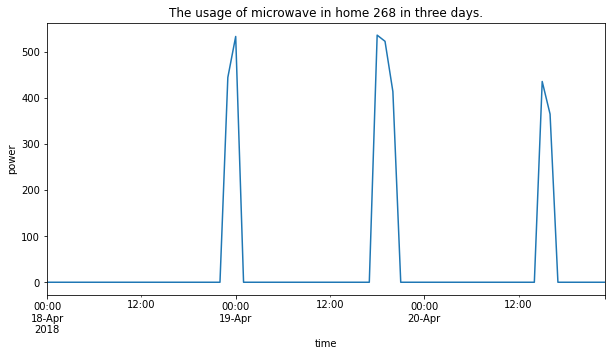

In [17]:
#pd.set_option('display.max_rows', 5000)
#pd.set_option('display.max_columns', 5000)

s2 = ideal_datas[0]['readings']
s2= s2.resample('60min').mean().fillna(0)
threeDay = (s2.index >= '2018-04-18') & (s2.index < '2018-04-21') #chosse three days
plt.figure(figsize=(10.0, 5.0))
s2[threeDay].plot()
plt.ylabel("power")
plt.title("The usage of " + appliance_name +" in home "+ homeid + " in three days.")
plt.show()

From the graph, we can know that the person in home 268 use 5 times of microwave from  2018-4-18 to 2018-4-20. 
And the time is around 00:00, 15:00 or 19:00, so we can assume that the person may use the microwave to make supper around 2018-4-19 00:00 and cook dinner around 2018-4-19 19:00 and make afternoon tea around 2018-4-20 15:00.

Then, let's draw the distribution of power in these three days to see how power distributes.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


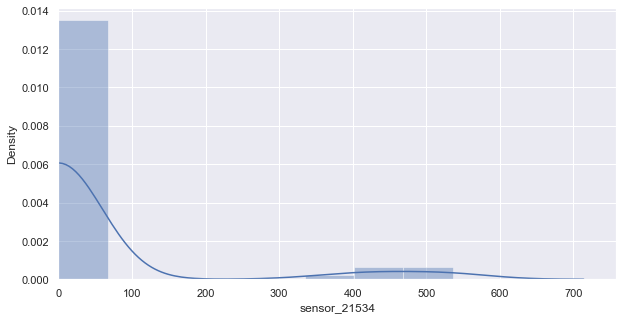

In [18]:
sns.set(color_codes = True)
plt.figure(figsize=(10.0, 5.0))
sns.distplot(s2[threeDay]).set_xlim(0) #it's no meaning when power < 0, so set the min of x >=0
plt.show()

From the graph, we can know that the distribution of power is mostly 0, and a small bit is around 500. This means that in most of the time in the three days, the microwave is not in used and once it is used, it's average power in 60 mins is about 500 watt.

#### 2. When does one family usually use that appliance?

In this part, we creat new data sets and analyse when does one family usually use one appliance.

The final task of this project is to analyse patterns of electrical appliances usage in these elderly families. So we may not care about the specific value of power but care about if this family use that appliance in one period. 

Firstly, we need to convet the power column to if_used.

If the average power in 60 mins is 0, we can assume that the appliance is not in used. On the other hand, if the average power in 60 mins is not 0, we can assume that the appliance is in used.

However, in some data sets(such as sensor_4859, which appeared in the setup part), the sensor may record 0 power as a small non-zero number, such as 2 or 3, for the reason that there may be some measurement errorit of the sensor. So, we can not simply assume that 0 is not in used. Instead, we can use the value of 75th percentile to define if it is in used. Because it is reasonable that most of time the appliance is not in used and the most value of power should represent the appliance is not in used.

In [19]:
data_s4859 = ideal.get(sensorid=4859)
data_s4859
homeid = data_s4859[0]['homeid']
appliance_name = data_s4859[0]['subtype']
s3 =data_s4859[0]['readings']
s3= s3.resample('60min').mean().fillna(0)
s3.describe()

count    10420.000000
mean        14.654057
std         84.926410
min          0.000000
25%          2.000000
50%          3.000000
75%          3.000000
max        937.000000
Name: sensor_4859, dtype: float64

The value of 50th percentile is 3 so we replace all the power data that <= 50th percentile in s3 to 0, and replace all the power data that > 50th percentile in s3 to 1 to represent if the appliance is in used.

In [20]:
not_in_used_loc = s3.values <= s3.quantile(0.5)
in_used_loc = s3.values > s3.quantile(0.5)
s3_new = s3.replace(s3[not_in_used_loc].values,0)
s3_new = s3_new.replace(s3_new[in_used_loc].values,1)

In [21]:
s3_new.describe()

count    10420.000000
mean         0.038964
std          0.193517
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: sensor_4859, dtype: float64

Here, we could see that the max is 1 and min and 75th percentile are 0 so it means that we change the power column to if_used successfully.

Next, we create a new dataframe to save the total count of if_used to get the times that household uses the appliance at each time of day.

In [22]:
# creat a time list that contains the each time of day(freq = 60mins).
times = []
for hour in range(24):
    for mins in [0]:
        time_datetime = datetime.time(hour,mins)
        time_str = time_datetime.strftime("%H:%M")
        times.append(time_str)
count_dic = {'time':times,'count of if_used':0}
# creat a new DataFrame from count_dic.
df1 = pd.DataFrame(data=count_dic)
df1

,time,count of if_used
0,00:00,0
1,01:00,0
2,02:00,0
3,03:00,0
4,04:00,0
...,...,...
19,19:00,0
20,20:00,0
21,21:00,0
22,22:00,0


Then, we count the data in s3_new and save them to df1.

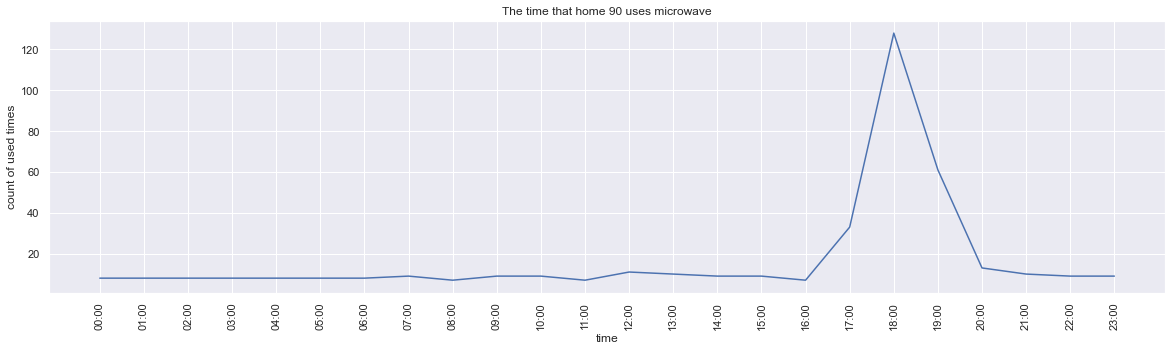

In [23]:
for time_str in df1['time']:
    timestamp = time.strptime(time_str, "%H:%M")
    timestamp.tm_hour
    loc_time = (s3_new.index.hour == timestamp.tm_hour) & (s3_new.index.minute == timestamp.tm_min)
    df1.loc[df1['time'] == time_str,'count of if_used'] = s3_new[loc_time].sum()
    
plt.figure(figsize=(20.0, 5.0))
plt.xticks(rotation=90)
plt.xlabel("time")
plt.ylabel("count of used times")
plt.title("The time that" +" home "+ homeid + " uses " + appliance_name)
plt.plot(df1['time'],df1['count of if_used'])
plt.show()


Well down! We got the gragh of the time that this family uses this appliance. From the gragh, we can find that this familiy usually use microwave around 18:00. It's reasonable to assume that this family prefer to use microwave to cook dinner than other time in a day.

Next, let's use scatter plot to see a more precise gragh.

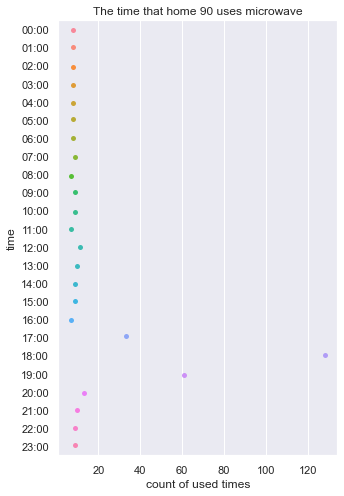

In [24]:
plt.figure(figsize=(5.0, 8.0))
sns.stripplot(y='time', x='count of if_used', data=df1)
plt.ylabel("time")
plt.xlabel("count of used times")
plt.title("The time that" +" home "+ homeid + " uses " + appliance_name)
plt.show()

Compared to the line plot above, this scatter plot show us more infomation of the count of used times. We can know that the familiy does not use microwave for 40-60 times in any period(in the line plot, it is replace by line so we can not clearly know this point). There is a gap around 17:00 and 19:00 (from 40 to 60 suddenly to 120+), which tells us that this family may have other things to deal with at 17:00 or 19:00. For example, in China, many people choose to watch the news broadcast at 19:00, so they may turn off microwave before 19:00. Or, this family may set an alarm to remind him/herself to use microwave after 17:00.

However, it may be also reasonable that this is because of our sampling frequency. It may be smooth for the original data, but there could be a gap for our data because we count once every half an hour(too long in this case)!

### How long a family use a appliance each time?
In this part, we will explore the length of time when one family use one appliance each time.

We use a 1 min sampling frequency this time because we need a more detailed usage range.

In [25]:
data_s4859 = ideal.get(sensorid=4859)
data_s4859
homeid = data_s4859[0]['homeid']
appliance_name = data_s4859[0]['subtype']
s4 =data_s4859[0]['readings']
s4= s4.resample('1min').mean().fillna(0)
s4.describe()

count    625142.000000
mean          1.134701
std          35.243028
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1494.000000
Name: sensor_4859, dtype: float64

In [26]:
not_in_used_loc = s4.values <= s4.quantile(0.5)
in_used_loc = s4.values > s4.quantile(0.5)
s4_new = s4.replace(s4[not_in_used_loc].values,0)
s4_new = s4_new.replace(s4_new[in_used_loc].values,1)

In [27]:
s4_new

time
2017-04-11 10:00:00    1.0
2017-04-11 10:01:00    1.0
2017-04-11 10:02:00    0.0
2017-04-11 10:03:00    0.0
2017-04-11 10:04:00    0.0
                      ... 
2018-06-19 12:57:00    0.0
2018-06-19 12:58:00    0.0
2018-06-19 12:59:00    0.0
2018-06-19 13:00:00    0.0
2018-06-19 13:01:00    1.0
Freq: T, Name: sensor_4859, Length: 625142, dtype: float64

Same as before, we have got a series of if_used in each 1 minute.

Next, we count the length of time when each using. And we store the data to df_time_using dataframe.

In [28]:
each_uasge_times = []
ifstart = False
ifend = False
sum_time = 0
for every_min in s4_new:
    if(every_min == 0.0):
        if(ifstart == True):
            ifend = True
        ifstart = False
        if(ifend == True):
            each_uasge_times.append(sum_time)
            ifend = False
        sum_time = 0
    else:
        ifstart = True
        sum_time = sum_time + 1
dic_time_using = {'length of time using':each_uasge_times}
df_time_using = pd.DataFrame(data=dic_time_using)
df_time_using

,length of time using
0,2
1,1
2,1
3,1
4,1
...,...
11083,1
11084,1
11085,1
11086,1


We need to count how many 1 appear, how many 2 appear,...

So we need to count the value in this dataframe with value_counts() method.

In [29]:
s__time_using_after_count = df_time_using['length of time using'].value_counts()
s__time_using_after_count

1     10824
2        99
4        75
3        51
5        18
6        10
7         4
10        3
8         3
9         1
Name: length of time using, dtype: int64

Then, we draw a pie plot to see the proportion of various usage time.

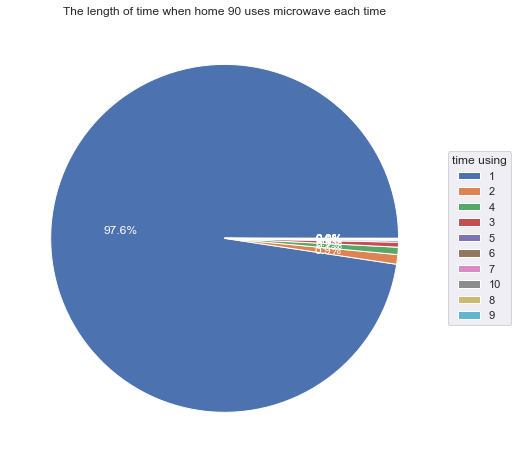

In [30]:
fig, ax = plt.subplots(figsize=(8, 8))

wedges, texts, autotexts = ax.pie(s__time_using_after_count,labels=s__time_using_after_count.index,autopct='%1.1f%%',
                                  textprops=dict(color="w"))

ax.legend(wedges, s__time_using_after_count.index,title="time using",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))

ax.set_title("The length of time when home " + homeid + " uses " + appliance_name + " each time")

plt.show()

From the above graph, we can know that in 97.6% of cases, this family will use microwave in 1 minute. So we can conclude that this family usually use microwave within 1 mintue. However, there are sometimes that this family use microwave for more than 5 mintues, which is relatively rare in the length of time the microwave is used in common life. It can be assumed that this family forgot to turn off the microwave or used microwave to make a hard cooked food.

#### What is the routine of one family to use all the appliances in the home?
In this part, we not only explore one appliance in one family but explore all the appliances in one family. We expect to darw a heatmap to find the routine of one family using appliances in one day.

We can use a dataframe which contains all the counts of various appliances if_used in one family. It will look like a wider df1 in the last part.

In [31]:
data_h1868 = smile.get(homeid=1868)

In [32]:
data_h1868

[{'homeid': '1868',
  'roomid': '1868',
  'room_type': 'room',
  'category': 'electric-appliance',
  'subtype': 'bed',
  'sensorid': '70508',
  'readings': time
  2020-01-08 14:42:45.630    1.3
  2020-01-08 14:45:00.627    1.4
  2020-01-08 14:46:11.680    1.3
  2020-01-08 14:58:07.627    1.4
  2020-01-08 14:59:21.610    1.3
                            ... 
  2020-10-17 22:43:13.047    1.3
  2020-10-17 22:43:26.010    1.3
  2020-10-17 22:47:33.073    1.4
  2020-10-17 22:50:52.040    1.3
  2020-10-17 22:55:48.057    1.4
  Name: sensor_70508, Length: 71777, dtype: float64},
 {'homeid': '1868',
  'roomid': '1868',
  'room_type': 'room',
  'category': 'electric-appliance',
  'subtype': 'coffee',
  'sensorid': '50508',
  'readings': time
  2020-01-08 15:19:33.547    0.1
  2020-01-08 16:19:33.477    0.1
  2020-01-08 17:19:33.417    0.1
  2020-01-08 18:19:33.420    0.1
  2020-01-08 19:19:33.277    0.1
                            ... 
  2020-10-17 18:43:09.140    0.1
  2020-10-17 19:43:09.080  

Have a qucik look at data_h1868（and also the describe, but it not easy to show here so I do not show it), we can find that it's same as before that some powers，which should be 0, are recorded as a small non-zero number. But this time we have lots of data, so we choose to use 50th percentiles to decide if one appliance is in used.

In [33]:
times = []
for hour in range(24):
    for mins in [0]:
        time_datetime = datetime.time(hour)
        time_str = time_datetime.strftime("%H:%M")
        times.append(time_str)
count_dic_p3 = {'time':times}
df_p3 = pd.DataFrame(data=count_dic_p3)
homeid = data_h1868[0]['homeid']

for one_appliance_data in data_h1868:
    appliance_name = one_appliance_data['subtype']
    appliance_s = one_appliance_data['readings']
    appliance_s = appliance_s.resample('60min').mean().fillna(0)
    not_in_used_loc = appliance_s.values <= appliance_s.quantile(0.5)
    in_used_loc = appliance_s.values > appliance_s.quantile(0.5)
    appliance_s_new = appliance_s.replace(appliance_s[not_in_used_loc].values,0)
    appliance_s_new = appliance_s_new.replace(appliance_s_new[in_used_loc].values,1)
    df_p3.insert(0,appliance_name,0)
    for time_str in df_p3['time']:
        timestamp = time.strptime(time_str, "%H:%M")
        loc_time = (appliance_s_new.index.hour == timestamp.tm_hour) & (appliance_s_new.index.minute == timestamp.tm_min)
        df_p3.loc[df_p3['time'] == time_str,appliance_name] = appliance_s_new[loc_time].sum()
df_p3 = df_p3.set_index('time') # to make df_p3 become a rectangular dataset
df_p3
    

,combi,tv,microwave,dishwasher,coffee,bed
time,,,,,,
00:00,160.0,76.0,0.0,11.0,0.0,178.0
01:00,163.0,50.0,0.0,11.0,0.0,175.0
02:00,165.0,46.0,0.0,11.0,0.0,175.0
03:00,157.0,42.0,0.0,11.0,0.0,175.0
04:00,162.0,32.0,0.0,11.0,0.0,172.0
...,...,...,...,...,...,...
19:00,164.0,170.0,8.0,21.0,26.0,175.0
20:00,164.0,149.0,3.0,17.0,17.0,176.0
21:00,163.0,96.0,0.0,15.0,0.0,174.0


Next, we draw the heatmap to see in each time period, how many times one appliance is in used.

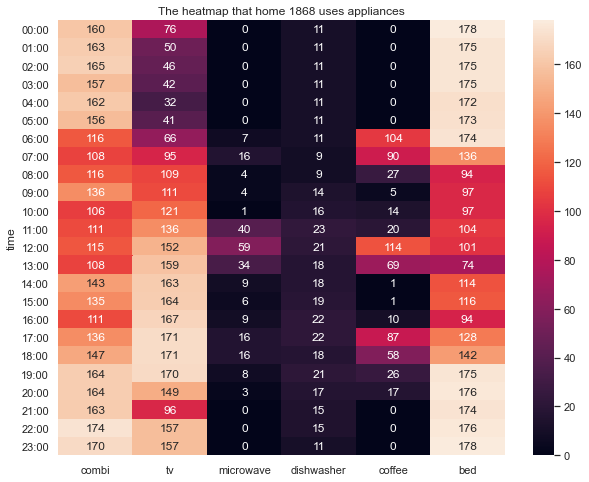

In [34]:
sns.set()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_p3, ax=ax,annot=True,fmt=".0f")
label_y = ax.get_yticklabels()
label_x = ax.get_xticklabels()
plt.title("The heatmap that" +" home "+ homeid + " uses appliances")
plt.show()

Through the heatmap, we can clearly see that how this family uses appliances. Combi will be mainly in used between !9:00-5:00, tv will be mainly in used between 10:00 - 19:00, microwave will be mainly in used between 11:00 - 13:00, dishwasher will be mainly in used around 12:00(but really seldom be in used), coffee will be mainly in used between 6:00-7:00, 12:00-13:00, and 17:00-18:00, and bed will be mainly in used between 19:00 - 6:00.

Thus, we may assume that the routine of elder in this family in one day will be like:

06:00 get up and make a cup of coffee

10:00 watch TV

11:00 have lunch and use microwave to cook sometimes, and still watch TV at the same time

12:00 make a cup of coffee and still watch TV at the same time

13:00 finish lunch and still watch TV or go to the bed without turning off the TV

17:00 make a cup of coffee and still watch TV at the same time

18:00 seldom use microwave to cook and still watch TV at the same time

19:00 begin to use combi(I don't know what it is in fact) and go to bed

00:00 prepare to turn off the TV most of time and go to sleep

For the routine above, we can find that this person really like watching TV and has a habit of dring coffe three times a day. The time of combi and bed is highly similar, so it may be concluded that bed and combi are in one room or the person just like to do the two thing together. And we may also confirm that the person is an elder by the bed time(just elders like to go to bed so early and can stay on the bed all the day in most of cases).

### For Assignment3 part 2: 3 home timeline patterns

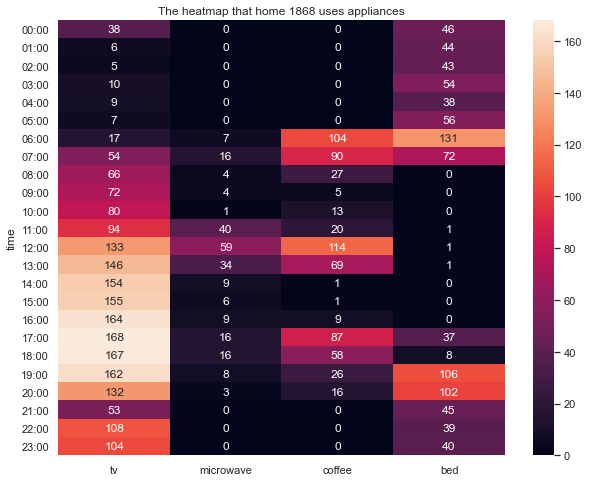

In [46]:
data_h1868 = smile.get(homeid=1868)
times = []
for hour in range(24):
    for mins in [0]:
        time_datetime = datetime.time(hour)
        time_str = time_datetime.strftime("%H:%M")
        times.append(time_str)
count_dic_p3 = {'time':times}
df_p3 = pd.DataFrame(data=count_dic_p3)
homeid = data_h1868[0]['homeid']

for one_appliance_data in data_h1868:
    appliance_name = one_appliance_data['subtype']
    appliance_s = one_appliance_data['readings']
    appliance_s = appliance_s.resample('60min').mean().fillna(0)
    not_in_used_loc = appliance_s.values <= 5 #appliance_s.quantile(0.3)
    in_used_loc = appliance_s.values > 5 #appliance_s.quantile(0.3)
    appliance_s_new = appliance_s.replace(appliance_s[not_in_used_loc].values,0)
    appliance_s_new = appliance_s_new.replace(appliance_s_new[in_used_loc].values,1)
    df_p3.insert(0,appliance_name,0)
    for time_str in df_p3['time']:
        timestamp = time.strptime(time_str, "%H:%M")
        loc_time = (appliance_s_new.index.hour == timestamp.tm_hour) & (appliance_s_new.index.minute == timestamp.tm_min)
        df_p3.loc[df_p3['time'] == time_str,appliance_name] = appliance_s_new[loc_time].sum()
df_p3 = df_p3.set_index('time') # to make df_p3 become a rectangular dataset
df_p3
df_p3 = df_p3.drop(columns="combi")
df_p3 = df_p3.drop(columns="dishwasher")

sns.set()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_p3, ax=ax,annot=True,fmt=".0f")
label_y = ax.get_yticklabels()
label_x = ax.get_xticklabels()
plt.title("The heatmap that" +" home "+ homeid + " uses appliances")
plt.show()
df_p3 = df_p3.astype(int)
df_p3.to_csv("1868pattern.csv",sep=',')

In [49]:
data_h1868

[{'homeid': '1868',
  'roomid': '1868',
  'room_type': 'room',
  'category': 'electric-appliance',
  'subtype': 'bed',
  'sensorid': '70508',
  'readings': time
  2020-01-08 14:42:45.630    1.3
  2020-01-08 14:45:00.627    1.4
  2020-01-08 14:46:11.680    1.3
  2020-01-08 14:58:07.627    1.4
  2020-01-08 14:59:21.610    1.3
                            ... 
  2020-10-17 22:43:13.047    1.3
  2020-10-17 22:43:26.010    1.3
  2020-10-17 22:47:33.073    1.4
  2020-10-17 22:50:52.040    1.3
  2020-10-17 22:55:48.057    1.4
  Name: sensor_70508, Length: 71777, dtype: float64},
 {'homeid': '1868',
  'roomid': '1868',
  'room_type': 'room',
  'category': 'electric-appliance',
  'subtype': 'coffee',
  'sensorid': '50508',
  'readings': time
  2020-01-08 15:19:33.547    0.1
  2020-01-08 16:19:33.477    0.1
  2020-01-08 17:19:33.417    0.1
  2020-01-08 18:19:33.420    0.1
  2020-01-08 19:19:33.277    0.1
                            ... 
  2020-10-17 18:43:09.140    0.1
  2020-10-17 19:43:09.080  

In [50]:
appliance_s

time
2020-01-08 14:00:00    1.750000
2020-01-08 15:00:00    1.747619
2020-01-08 16:00:00    1.750000
2020-01-08 17:00:00    1.727273
2020-01-08 18:00:00    1.766667
                         ...   
2020-10-17 18:00:00    1.766667
2020-10-17 19:00:00    1.800000
2020-10-17 20:00:00    1.755556
2020-10-17 21:00:00    1.800000
2020-10-17 22:00:00    1.800000
Freq: 60T, Name: sensor_30508, Length: 6801, dtype: float64

In [51]:
appliance_s_new

time
2020-01-08 14:00:00    0.0
2020-01-08 15:00:00    0.0
2020-01-08 16:00:00    0.0
2020-01-08 17:00:00    0.0
2020-01-08 18:00:00    0.0
                      ... 
2020-10-17 18:00:00    0.0
2020-10-17 19:00:00    0.0
2020-10-17 20:00:00    0.0
2020-10-17 21:00:00    0.0
2020-10-17 22:00:00    0.0
Freq: 60T, Name: sensor_30508, Length: 6801, dtype: float64

In [52]:
df_p3

,tv,microwave,coffee,bed
time,,,,
00:00,38,0,0,46
01:00,6,0,0,44
02:00,5,0,0,43
03:00,10,0,0,54
04:00,9,0,0,38
...,...,...,...,...
19:00,162,8,26,106
20:00,132,3,16,102
21:00,53,0,0,45


##### Timeline:

07:00 - 19:00 TV

11:00 - 13:00 microwave

06:00 - 07:00, 12:00 - 13:00, 17:00 - 18:00 coffee

19:00 - 06:00 sleepling

##### Analysis:


For the routine above, we can find that this person really like watching TV and has a habit of dring coffe three times a day. At noon, this person may like use microwave to cook the dinner. We may also confirm that the person is an elder by the bed time(just elders like to go to bed so early).


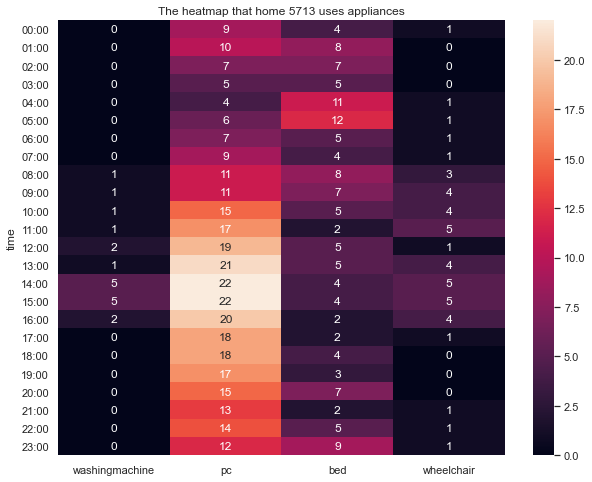

In [36]:
data_h1868 = smile.get(homeid=5713)
times = []
for hour in range(24):
    for mins in [0]:
        time_datetime = datetime.time(hour)
        time_str = time_datetime.strftime("%H:%M")
        times.append(time_str)
count_dic_p3 = {'time':times}
df_p3 = pd.DataFrame(data=count_dic_p3)
homeid = data_h1868[0]['homeid']

for one_appliance_data in data_h1868:
    appliance_name = one_appliance_data['subtype']
    appliance_s = one_appliance_data['readings']
    appliance_s = appliance_s.resample('60min').mean().fillna(0)
    not_in_used_loc = appliance_s.values <= 5 #appliance_s.quantile(0.3)
    in_used_loc = appliance_s.values > 5 #appliance_s.quantile(0.3)
    appliance_s_new = appliance_s.replace(appliance_s[not_in_used_loc].values,0)
    appliance_s_new = appliance_s_new.replace(appliance_s_new[in_used_loc].values,1)
    df_p3.insert(0,appliance_name,0)
    for time_str in df_p3['time']:
        timestamp = time.strptime(time_str, "%H:%M")
        loc_time = (appliance_s_new.index.hour == timestamp.tm_hour) & (appliance_s_new.index.minute == timestamp.tm_min)
        df_p3.loc[df_p3['time'] == time_str,appliance_name] = appliance_s_new[loc_time].sum()
df_p3 = df_p3.set_index('time') # to make df_p3 become a rectangular dataset
df_p3
sns.set()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_p3, ax=ax,annot=True,fmt=".0f")
label_y = ax.get_yticklabels()
label_x = ax.get_xticklabels()
plt.title("The heatmap that" +" home "+ homeid + " uses appliances")
plt.show()
df_p3 = df_p3.astype(int);
df_p3.to_csv("5713pattern.csv",sep=',')

##### Timeline:

10:00 - 20:00 PC

14:00 - 15:00 washingmachine

06:00 - 11:00, 13:00 - 14:00 wheelchair

23:00 - 05:00 sleepling

##### Analysis:


For the routine above, we can find that this person really like using PC. He usually sleep from 23:00 - 05:00(the sleep time is less than the other elders in the nursing home. He may sit on the wheelchair after getting up at 05:00, then have a dinner at 12:00, and continue to sit on the wheelchair for the afernoon. If he need to use a washingmachine, he will choose to use it around 14:00.


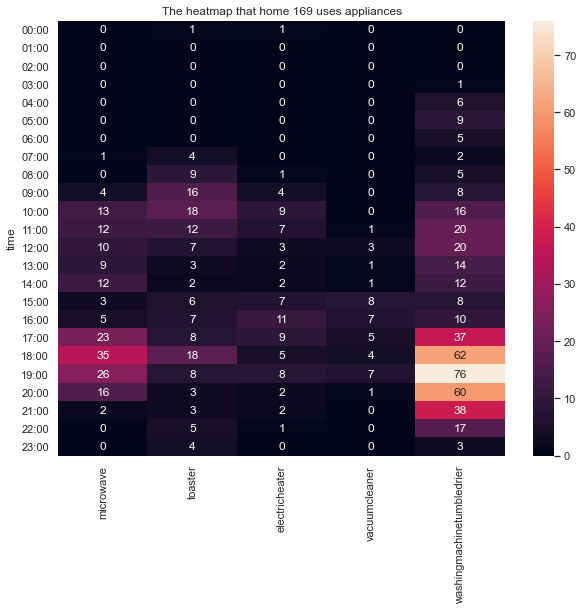

In [37]:
data_h1868 = ideal.get(homeid=169)
times = []
for hour in range(24):
    for mins in [0]:
        time_datetime = datetime.time(hour)
        time_str = time_datetime.strftime("%H:%M")
        times.append(time_str)
count_dic_p3 = {'time':times}
df_p3 = pd.DataFrame(data=count_dic_p3)
homeid = data_h1868[0]['homeid']

for one_appliance_data in data_h1868:
    appliance_name = one_appliance_data['subtype']
    appliance_s = one_appliance_data['readings']
    appliance_s = appliance_s.resample('60min').mean().fillna(0)
    not_in_used_loc = appliance_s.values <= 5 #appliance_s.quantile(0.7)
    in_used_loc = appliance_s.values > 5 #appliance_s.quantile(0.7)
    appliance_s_new = appliance_s.replace(appliance_s[not_in_used_loc].values,0)
    appliance_s_new = appliance_s_new.replace(appliance_s_new[in_used_loc].values,1)
    df_p3.insert(0,appliance_name,0)
    for time_str in df_p3['time']:
        timestamp = time.strptime(time_str, "%H:%M")
        loc_time = (appliance_s_new.index.hour == timestamp.tm_hour) & (appliance_s_new.index.minute == timestamp.tm_min)
        df_p3.loc[df_p3['time'] == time_str,appliance_name] = appliance_s_new[loc_time].sum()
df_p3 = df_p3.set_index('time') # to make df_p3 become a rectangular dataset
df_p3 = df_p3.drop(columns="fridgefreezer")
df_p3 = df_p3.drop(columns="other")
df_p3 = df_p3.drop(columns="dishwasher")
df_p3 = df_p3.drop(columns="grill")
sns.set()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_p3, ax=ax,annot=True,fmt=".0f")
label_y = ax.get_yticklabels()
label_x = ax.get_xticklabels()
plt.title("The heatmap that" +" home "+ homeid + " uses appliances")
plt.show()
df_p3 = df_p3.astype(int);
df_p3.to_csv("169pattern.csv",sep=',')

##### Timeline:

10:00 - 14:00, 17:00 - 20:00 microwave

09:00 - 11:00, 18:00 toaster

10:00 - 11:00, 16:00 - 19:00 electricheater

15:00 - 19:00 vacuumcleaner

17:00 - 21:00 washing machine


##### Analysis:


For the routine above, we can find that this person uses microwave and washing machines relatively frequently, both of which are used around 18:00 or 19:00 in the evening. He may use toaster sometimes to make a breakfast aroud 10:00. He may use electricheater sometimes to make a hot water around 10:00 or around late afternoon or early evening. If he need to use a vacuumcleaner, he will choose to use it in the afternoon or evening.

### Relationships Between Variables

#### What is the relationship between ages of elders and average powers when they use microwave?

The data in extenal file provides the age of elders. It's interseting to have a look at the relationship between ages of elders and average powers when they use appliance. Does it possible that older people like to use more power when using microwave?

In [38]:
#get data
data_microwaves = smile.get(subtype = 'microwave')
extra_data = pd.read_csv('./IAM_Data/Energy data participants.csv')
extra_data = extra_data.dropna() #drop some NaN values
extra_data

,ID,Gender,DateOfBirth,Age,StaffPlanConditions,CareSysCondition,Location
0,2059.0,M,1954/9/21,66,None,None,Aberdeen
1,4206.0,M,1954/12/22,54,None,Mobility Issues,Livingston
2,1868.0,F,1959/6/29,61,None,Cerebral Palsy,Aberdeen
3,2688.0,M,1967/8/19,53,None,Mental Health Issue,Edinburgh
4,2583.0,M,Nil,70+,None,COPD,Edinburgh
5,1874.0,M,1952/10/1,68,None,Brain Injury,Aberdeen
6,5713.0,M,Nil,Nil,None,?,Edinburgh


The age for ID 5713 is not a number, so we need to drop this row.

The age for ID 2583 is 70+, which is not a specific number and may make some troubles when we do variable analysis. We replace it to 70 here.

In [39]:
extra_data = extra_data.drop(6)
extra_data = extra_data.replace('70+','70')
extra_data

,ID,Gender,DateOfBirth,Age,StaffPlanConditions,CareSysCondition,Location
0,2059.0,M,1954/9/21,66,None,None,Aberdeen
1,4206.0,M,1954/12/22,54,None,Mobility Issues,Livingston
2,1868.0,F,1959/6/29,61,None,Cerebral Palsy,Aberdeen
3,2688.0,M,1967/8/19,53,None,Mental Health Issue,Edinburgh
4,2583.0,M,Nil,70,None,COPD,Edinburgh
5,1874.0,M,1952/10/1,68,None,Brain Injury,Aberdeen


The tpye ID is float, which will make trouble in the following merge step, so we transfer it to str type(we need to firstly transfer it to int type to delete '.0').

In [40]:
extra_data['ID'] = extra_data['ID'].astype(int)
extra_data['ID'] = extra_data['ID'].astype(str)
extra_data

,ID,Gender,DateOfBirth,Age,StaffPlanConditions,CareSysCondition,Location
0,2059,M,1954/9/21,66,None,None,Aberdeen
1,4206,M,1954/12/22,54,None,Mobility Issues,Livingston
2,1868,F,1959/6/29,61,None,Cerebral Palsy,Aberdeen
3,2688,M,1967/8/19,53,None,Mental Health Issue,Edinburgh
4,2583,M,Nil,70,None,COPD,Edinburgh
5,1874,M,1952/10/1,68,None,Brain Injury,Aberdeen


Next, we calulate the average power when eldes are using microwaves.

We use a 10s sampling frequency because we need more accurate values here. Originally, the sensor collects data every seven seconds when the electrical appliance is working, so we use a similar number of 7 - 10 seconds to restore the electrical power to the greatest extent.

The microwave power is normally more than 100w, so we use 10 here to decide if microwave is in used.

In [41]:
average_powers = []
homeids = []
for data_microwave in data_microwaves:
    homeid = data_microwave['homeid']
    microwave_s = data_microwave['readings']
    microwave_s = microwave_s.resample('10s').mean().fillna(0)
    not_in_used_loc = microwave_s.values <= 10
    in_used_loc = microwave_s.values > 10
    count_in_used = (np.sum(in_used_loc == True))
    sum_power = microwave_s[in_used_loc].sum()
    average_power = sum_power/count_in_used
    homeids.append(homeid)
    average_powers.append(average_power)

dic_average_powers = {'ID':homeids,'average_power':average_powers}
df_average_power = pd.DataFrame(dic_average_powers)
df_average_power

,ID,average_power
0,4206,382.025034
1,2059,523.903733
2,1874,900.587500
3,1868,689.074664
4,2583,765.033482
5,2688,643.526680


Then, we merage the two dateframe together according to homeid.

And we transfer the type of age to int beacuse we need number type when we are doing variable analysis.

In [42]:
df_merge = pd.merge(extra_data,df_average_power,how='inner',on='ID')
df_merge['Age'] = df_merge['Age'].astype(int)
df_merge

,ID,Gender,DateOfBirth,Age,StaffPlanConditions,CareSysCondition,Location,average_power
0,2059,M,1954/9/21,66,None,None,Aberdeen,523.903733
1,4206,M,1954/12/22,54,None,Mobility Issues,Livingston,382.025034
2,1868,F,1959/6/29,61,None,Cerebral Palsy,Aberdeen,689.074664
3,2688,M,1967/8/19,53,None,Mental Health Issue,Edinburgh,643.526680
4,2583,M,Nil,70,None,COPD,Edinburgh,765.033482
5,1874,M,1952/10/1,68,None,Brain Injury,Aberdeen,900.587500


Next, we use lmplot or regplot to see the relationship between age and average_power.

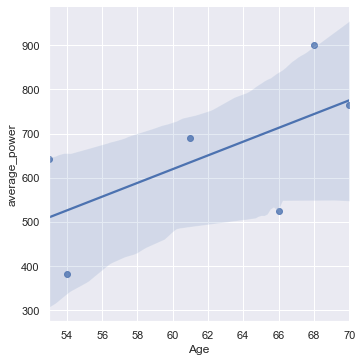

In [43]:
sns.lmplot( x="Age", y="average_power", data=df_merge)
plt.show()

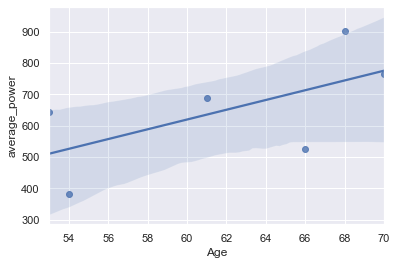

In [44]:
sns.regplot( x="Age", y="average_power", data=df_merge)
plt.show()

From the above two graphs, we can see that there is a certain linear relationship between age and average power. The older the age, the greater the average power when using the microwave. But this linear relationship is not very strict. In order to quantify the relationship between them, we use linear regression for analysis.

In [45]:
stats.linregress(df_merge['Age'],df_merge['average_power'])

LinregressResult(slope=15.581651654656111, intercept=-315.3705537561573, rvalue=0.6203304503539948, pvalue=0.1888589637147791, stderr=9.85065424352598)

The slope is 15.581651654656111, which means that the older the age, the greater the average power when using the microwave. The rvalue is 0.6203304503539948, which is not very close to 1. It means that the linear correlation between age and average power is not significant. The pvalue is 0.18885896, which relates to a possibility of the null hypothesis, which is that the slope is zero. If we set α=0.05, pvalue is more than α. So we can conclude that in this case, null hypothesis is not rejected.

Though the linear correlation between age and average power is not significant, we can still assume the slight correlation is because within the age increasing, elders prefer to more cooked food.

In fact, we just have 6 sets of valid data here, which is too small compared to the normal data set. So our conclsion may become more meaningful with the bigger scale of data sets.

## Reflect and Hypothesise:
I think I have written my hypothesis below each graghs. So here I just say something about data reflection and how I could go about testing hypothesis.

### Data Reflection

This data set is really difficult to handle with. We don't have too many columns of data but have many rows. The orignal data is not distributed evenly over time so we need to resample it. And we want to find patterns of elders using appliances so we need to convert the power data to some more meaningful data, such as if_used in this notebook. We create many new series and dataframe to store these new data, and draw kinds of graghs to find some patterns. During this proess, we faced many problems but we solved them one by one at last. And luckly, we find some patterns. We can use the data set to find when one family uses appliances every day, in which order and in what time. By this heatmap, we can assume a time schedule for this family and guess some habits of this family. On the other hand, we use the extenal file to explore if there is a relationship between ages of elders and average powers when they use microwave. Though the linear correlation is not significant, we still got some conclusions. And we discovered the importance of data volume.

The power of data is inestimable, and I hope that what I have gained in this course can be used someday in the future.

### How I could go about testing hypothesis？

The mainly hypothesis is this notebook is the pattern of one family using appliances. To test it, we can use the sensors to record longer time(but need to some patterns may be changed with time) and check our hypothesis. We may also do a user research, to do a interview or do a observation, with these families if it's possible. And what's more, we can use machine learing to train a model from these data sets, and make a prediction to their behaviour and test it by using methods above.